# import

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from rastermap import Rastermap
from scipy.signal import savgol_filter
cmap = plt.cm.get_cmap('viridis_r')

import os
import scipy.io
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import pearsonr, zscore
from scipy.io import savemat
import random
import utils
from sklearn.decomposition import PCA
plt.rcParams['axes.facecolor'] = 'white'
outcome_list = ['Hit', 'Miss', 'FA', 'CR']
mouse_names = ['jl009', 'fz017', 'fz009', 'fz006']
data_paths = ["Z:/Jenni/jl009/behavimaging.mat",
             "W:/Jenni/fz017/behavimaging.mat",
             "Y:/Jenni/fz009/behavimaging.mat",
             "Y:/sarah/fz006/behavimaging.mat"]
disks = ['Z', 'W', 'Y', 'Y']

mouse_id = 0
thresh = 0.05 # correlation threshold for selecting important axons
mouse_name = mouse_names[mouse_id]
disk = disks[mouse_id]

data_path = "{}_behavimaging.mat".format(mouse_name)
mat = scipy.io.loadmat(data_path)
data = mat['behavimaging']
nBlocks = data.shape[-1]
nDays = data[0, -1]['day'][0][0]

valid_days = []
for day in range(1, nDays+1):
    iblocks = utils.daily_blocks(data, day)
    if len(iblocks)>0:
        valid_days.append(day)
        
# cmap = plt.cm.get_cmap('viridis_r')
if mouse_name == 'jl009':
    valid_days = [1, 2, 3, 5, 6, 7, 8, 9, 15]
    im_proportion = 0.3
if mouse_name == 'fz017':
    valid_days = [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 23, 24, 25, 26]
    im_proportion = 0.2
    
day_groups_all = [[[1,2,3], [5,6], [7,8,9], [15]], 
                 [[1,2,4,5], [6,7,8,9,10], [11, 12,14,15], [17,23], [24,25,26]],
                 [[1,2], [5], [11]], # 15
                 [[1,2,3,4,5], [6,9,10], [11,15]]]

# Pure sensory selectivity
plot weights of Miss and CR trials, and weights of Hit and FA trials.

In [153]:
mouse_id = 0
avg_weight = False # either use (NA, NF) as input or use aveage spks across axons (NF) as input.
pre_window = 45
post_window = 45

mouse_name = mouse_names[mouse_id]
disk = disks[mouse_id]

data_path = "{}_behavimaging.mat".format(mouse_name)
mat = scipy.io.loadmat(data_path)
data = mat['behavimaging']
blocks = []
valid_days = []

for day in range(1, nDays+1):
    iblocks = utils.daily_blocks(data, day)
    if len(iblocks)>0:
        valid_days.append(day)

if mouse_name == 'jl009':
    valid_days = [1, 2, 3, 5, 6, 7, 8, 9, 15]
if mouse_name == 'fz017':
    valid_days = [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 23, 24, 25, 26]
if mouse_name == 'fz009':
    valid_days = [1,2,5,11]

rl_performance = []
pb_performance = []
hf_accs = []
hf_weights = []
mc_accs = []
mc_weights = []

for i, day in enumerate(valid_days):
    print('-------------------day {}---------------------'.format(day))
    iblocks = utils.daily_blocks(data, day)
    if len(iblocks)>0:
        daily_cues = []
        daily_outcomes = []
        daily_responses = []
        daily_firstlicks = []
        daily_alllicks = []
        daily_responses = []
        valid = True
        for j in iblocks:
            block = data[0, j]
            # normalize doesn't have much effect on the result, so set it to OBlse
            cues, outcomes, firstlicks, stim_resp, alllicks = utils.block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False)
            if len(daily_responses) > 0:
                if daily_responses[0].shape != stim_resp.shape:
                    valid = False
            if valid == True:
                daily_responses.append(stim_resp)
                daily_cues.append(cues)
                daily_outcomes.append(outcomes)
                daily_firstlicks.append(firstlicks)
                daily_alllicks.append(alllicks)

        daily_cues = np.hstack(daily_cues)
        daily_outcomes = np.hstack(daily_outcomes)
        daily_alllicks = np.vstack(daily_alllicks)
        daily_responses = np.vstack(daily_responses)

        performance = (np.sum(daily_outcomes==1) + np.sum(daily_outcomes==4))/len(daily_outcomes)
        print('[day {}, behavior performance {:.2f}%]'.format(day, performance*100))
        rl_performance.append(performance)
        pb_ind = np.hstack([np.where(daily_cues==3)[0], np.where(daily_cues==4)[0]])
        pb_outcomes = daily_outcomes[pb_ind]
        performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)
        pb_performance.append(performance)

        pb_alllicks = daily_alllicks[pb_ind]
        pb_outcomes = daily_outcomes[pb_ind]

        stim = np.ones(daily_cues.shape)
        OA_idx = np.where(daily_cues==2)[0]
        OB_idx = np.where(daily_cues==4)[0]
        stim[OA_idx] = 0
        stim[OB_idx] = 0 # target: 1    foil: 0, regardless of probe or reinforce trial

        # Hit and FA
        hf_ind = np.hstack([np.where(daily_outcomes==1)[0], np.where(daily_outcomes==3)[0]])
        if len(hf_ind) > 20:
            stim_resp = daily_responses[hf_ind, :, pre_window:]
            NT, NA, NF = stim_resp.shape
            if avg_weight:
                spks = stim_resp.mean(axis=1)
            else:
                spks = stim_resp.reshape(stim_resp.shape[0], -1)
            acc, weights = classifier(spks, stim[hf_ind])
            if acc and (not avg_weight):
                weights = weights.reshape((NA, NF))
        else:
            acc, weights = False, False
        hf_accs.append(acc)
        hf_weights.append(weights)
        print('accuracy predicting stimulus identity(Hit and FA): ', acc)

        # Miss and CR
        mc_ind = np.hstack([np.where(daily_outcomes==2)[0], np.where(daily_outcomes==4)[0]])
        if len(mc_ind) > 20:
            stim_resp = daily_responses[mc_ind, :, pre_window:]
            NT, NA, NF = stim_resp.shape
            if avg_weight:
                spks = stim_resp.mean(axis=1)
            else:
                spks = stim_resp.reshape(stim_resp.shape[0], -1)
            acc, weights = classifier(spks, stim[mc_ind])
            if acc and (not avg_weight):
                weights = weights.reshape((NA, NF))
        else:
            acc, weights = False, False
        mc_accs.append(acc)
        mc_weights.append(weights)
        print('accuracy predicting stimulus identity(Miss and CR): ', acc)


-------------------day 1---------------------
[day 1, behavior performance 51.00%]
valid samples: 138
accuracy predicting stimulus identity(Hit and FA):  0.6978260869565217
valid samples: 156
accuracy predicting stimulus identity(Miss and CR):  0.598076923076923
-------------------day 2---------------------
[day 2, behavior performance 52.67%]
valid samples: 164
accuracy predicting stimulus identity(Hit and FA):  0.5145454545454544
valid samples: 120
accuracy predicting stimulus identity(Miss and CR):  0.6375
-------------------day 3---------------------
[day 3, behavior performance 61.67%]
valid samples: 138
accuracy predicting stimulus identity(Hit and FA):  0.6413043478260869
valid samples: 92
accuracy predicting stimulus identity(Miss and CR):  0.5290322580645161
-------------------day 5---------------------
[day 5, behavior performance 60.50%]
valid samples: 154
accuracy predicting stimulus identity(Hit and FA):  0.7038461538461538
no avalible binary labels for classifier
accuracy

### weights

#### Hit and FA

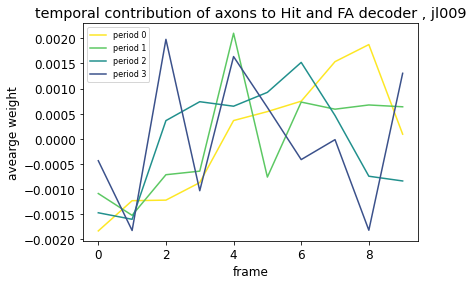

In [154]:
smooth = False
day_groups = day_groups_all[mouse_id]
title = 'temporal contribution of axons to Hit and FA decoder , {}'.format(mouse_name)
if smooth:
    figname = 'figure2206/decode_activity/weight_decoding_HitFA_period_smooth_{}'.format(mouse_name)
else:
    figname = 'figure2206/decode_activity/weight_decoding_HitFA_period_raw_{}'.format(mouse_name)
if avg_weight:
    figname += '_avg'
    utils.plot_avg_weight(day_groups, valid_days, hf_weights, hf_accs, title, smooth)
else:
    utils.plot_weight(day_groups, valid_days, hf_weights, hf_accs, title, smooth)

#### Miss and CR

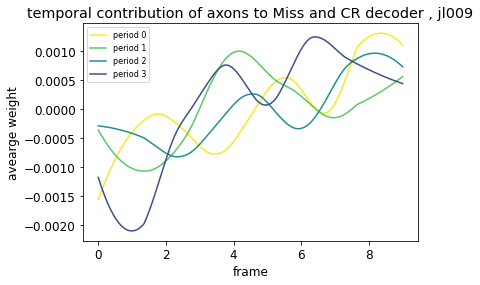

In [155]:
title = 'temporal contribution of axons to Miss and CR decoder , {}'.format(mouse_name)
if smooth:
    figname = 'figure2206/decode_activity/weight_decoding_MissCR_period_smooth_{}'.format(mouse_name)
else:
    figname = 'figure2206/decode_activity/weight_decoding_MissCR_period_raw_{}'.format(mouse_name)
if avg_weight:
    figname += '_avg'
    utils.plot_avg_weight(day_groups, valid_days, mc_weights, mc_accs, title, smooth=True)
else:
    utils.plot_weight(day_groups, valid_days, mc_weights, mc_accs, title, smooth=True)

### accuracy

In [ ]:
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 12
plt.figure(figsize=(10, 5))
x = np.arange(len(valid_days))
xx, yy = utils.remove_false(x, hf_accs)
plt.plot(xx, yy, label='Hit and FA', color='blue')
xx, yy = utils.remove_false(x, mc_accs)
plt.plot(xx, yy, label='Miss and CR', color='orange')
xx, yy = utils.remove_false(x, rl_performance)
plt.plot(xx, yy, label='reinforce', color='black', linestyle=':')
xx, yy = utils.remove_false(x, pb_performance)
plt.plot(xx, yy, label='probe', color='red', linestyle=':')
plt.xlabel('day')
plt.ylabel('accuracy')
plt.title('decoding accuracy, {}'.format(mouse_name))
plt.axhline(0.5, linestyle=':', color='gray', alpha=0.5)
plt.ylim([0.3,1])
plt.legend(loc=4)
plt.xticks(x, labels=valid_days)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.savefig('figure2206/decode_activity/decoding_HitFA_MissCR_fromspk_day_raw_{}'.format(mouse_name))
# plt.close()  

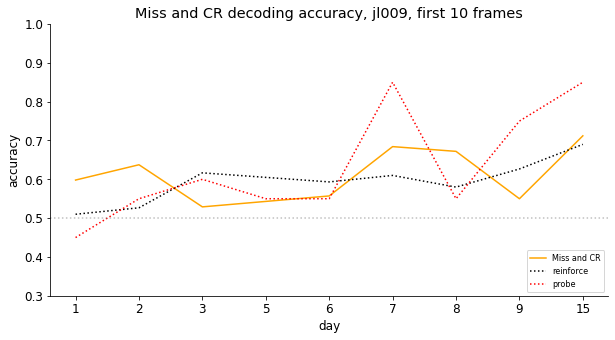

In [157]:
plt.figure(figsize=(10, 5))
x = np.arange(len(valid_days))
xx, yy = utils.remove_false(x, mc_accs)
plt.plot(xx, yy, label='Miss and CR', color='orange')
xx, yy = utils.remove_false(x, rl_performance)
plt.plot(xx, yy, label='reinforce', color='black', linestyle=':')
xx, yy = utils.remove_false(x, pb_performance)
plt.plot(xx, yy, label='probe', color='red', linestyle=':')
plt.xlabel('day')
plt.ylabel('accuracy')
plt.title('Miss and CR decoding accuracy, {}'.format(mouse_name))
plt.axhline(0.5, linestyle=':', color='gray', alpha=0.5)
plt.ylim([0.3,1])
plt.legend(loc=4)
plt.xticks(x, labels=valid_days)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.savefig('figure2206/decode_activity/decoding_MissCR_fromspk_day_raw_{}'.format(mouse_name))
# plt.close()  

## all
run all mice at once

In [29]:
mouse_id = 0
pre_window = 45
post_window = 45
for mouse_id in range(2,4):
    mouse_name = mouse_names[mouse_id]
    disk = disks[mouse_id]

    data_path = "{}_behavimaging.mat".format(mouse_name)
    mat = scipy.io.loadmat(data_path)
    data = mat['behavimaging']
    blocks = []
    valid_days = []

    for day in range(1, nDays+1):
        iblocks = utils.daily_blocks(data, day)
        if len(iblocks)>0:
            valid_days.append(day)

    if mouse_name == 'jl009':
        valid_days = [1, 2, 3, 5, 6, 7, 8, 9, 15]
    if mouse_name == 'fz017':
        valid_days = [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 23, 24, 25, 26]
    if mouse_name == 'fz009':
        valid_days = [1,2,5,11]
        
    rl_performance = []
    pb_performance = []
    hf_accs = []
    hf_weights = []
    mc_accs = []
    mc_weights = []

    for i, day in enumerate(valid_days):
        print('-------------------day {}---------------------'.format(day))
        iblocks = utils.daily_blocks(data, day)
        if len(iblocks)>0:
            daily_cues = []
            daily_outcomes = []
            daily_responses = []
            daily_firstlicks = []
            daily_alllicks = []
            daily_responses = []
            valid = True
            for j in iblocks:
                block = data[0, j]
                # normalize doesn't have much effect on the result, so set it to OBlse
                cues, outcomes, firstlicks, stim_resp, alllicks = utils.block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False)
                if len(daily_responses) > 0:
                    if daily_responses[0].shape != stim_resp.shape:
                        valid = False
                if valid == True:
                    daily_responses.append(stim_resp)
                    daily_cues.append(cues)
                    daily_outcomes.append(outcomes)
                    daily_firstlicks.append(firstlicks)
                    daily_alllicks.append(alllicks)

            daily_cues = np.hstack(daily_cues)
            daily_outcomes = np.hstack(daily_outcomes)
            daily_alllicks = np.vstack(daily_alllicks)
            daily_responses = np.vstack(daily_responses)

            performance = (np.sum(daily_outcomes==1) + np.sum(daily_outcomes==4))/len(daily_outcomes)
            print('[day {}, behavior performance {:.2f}%]'.format(day, performance*100))
            rl_performance.append(performance)
            pb_ind = np.hstack([np.where(daily_cues==3)[0], np.where(daily_cues==4)[0]])
            pb_outcomes = daily_outcomes[pb_ind]
            performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)
            pb_performance.append(performance)
            
            pb_alllicks = daily_alllicks[pb_ind]
            pb_outcomes = daily_outcomes[pb_ind]
            
            stim = np.ones(daily_cues.shape)
            OA_idx = np.where(daily_cues==2)[0]
            OB_idx = np.where(daily_cues==4)[0]
            stim[OA_idx] = 0
            stim[OB_idx] = 0 # target: 1    foil: 0, regardless of probe or reinforce trial
            
            # Hit and FA
            hf_ind = np.hstack([np.where(daily_outcomes==1)[0], np.where(daily_outcomes==3)[0]])
            if len(hf_ind) > 20:
                stim_resp = daily_responses[hf_ind, :, pre_window:]
                NT, NA, NF = stim_resp.shape
                spks = stim_resp.reshape(stim_resp.shape[0], -1)
                acc, weights = classifier(spks, stim[hf_ind])
                if acc:
                    weights = weights.reshape((NA, NF))
            else:
                acc, weights = False, False
            hf_accs.append(acc)
            hf_weights.append(weights)
            print('accuracy predicting stimulus identity(Hit and FA): ', acc)
            
            # Miss and CR
            mc_ind = np.hstack([np.where(daily_outcomes==2)[0], np.where(daily_outcomes==4)[0]])
            if len(mc_ind) > 20:
                stim_resp = daily_responses[mc_ind, :, pre_window:]
                NT, NA, NF = stim_resp.shape
                spks = stim_resp.reshape(stim_resp.shape[0], -1)
                acc, weights = classifier(spks, stim[mc_ind])
                if acc:
                    weights = weights.reshape((NA, NF))
            else:
                acc, weights = False, False
            mc_accs.append(acc)
            mc_weights.append(weights)
            print('accuracy predicting stimulus identity(Miss and CR): ', acc)
            
    plt.rcParams['font.size'] = 15
    plt.rcParams['legend.fontsize'] = 12
    plt.figure(figsize=(10, 5))
    x = np.arange(len(valid_days))
    xx, yy = utils.remove_false(x, hf_accs)
    plt.plot(xx, yy, label='Hit and FA', color='blue')
    xx, yy = utils.remove_false(x, mc_accs)
    plt.plot(xx, yy, label='Miss and CR', color='orange')
    xx, yy = utils.remove_false(x, rl_performance)
    plt.plot(xx, yy, label='reinforce', color='black', linestyle=':')
    xx, yy = utils.remove_false(x, pb_performance)
    plt.plot(xx, yy, label='probe', color='red', linestyle=':')
    plt.xlabel('day')
    plt.ylabel('accuracy')
    plt.title('Hit or FA decoding accuracy, {}'.format(mouse_name))
    plt.axhline(0.5, linestyle=':', color='gray', alpha=0.5)
    plt.ylim([0.3,1])
    plt.legend(loc=4)
    plt.xticks(x, labels=valid_days)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.savefig('figure2206/decode_activity/decoding_HitFA_MissCR_fromspk_day_raw_{}'.format(mouse_name))
    plt.close()  
    
    plt.figure(figsize=(10, 5))
    x = np.arange(len(valid_days))
    xx, yy = utils.remove_false(x, mc_accs)
    plt.plot(xx, yy, label='Miss and CR', color='orange')
    xx, yy = utils.remove_false(x, rl_performance)
    plt.plot(xx, yy, label='reinforce', color='black', linestyle=':')
    xx, yy = utils.remove_false(x, pb_performance)
    plt.plot(xx, yy, label='probe', color='red', linestyle=':')
    plt.xlabel('day')
    plt.ylabel('accuracy')
    plt.title('Hit or FA decoding accuracy, {}'.format(mouse_name))
    plt.axhline(0.5, linestyle=':', color='gray', alpha=0.5)
    plt.ylim([0.3,1])
    plt.legend(loc=4)
    plt.xticks(x, labels=valid_days)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.savefig('figure2206/decode_activity/decoding_MissCR_fromspk_day_raw_{}'.format(mouse_name))
    plt.close()  
    
    plt.rcParams['font.size'] = 12
    plt.rcParams['legend.fontsize'] = 8
    day_groups = day_groups_all[mouse_id]
    cmap = plt.cm.get_cmap('viridis_r')

    plt.figure(figsize=(6, 4))
    for i, days in enumerate(day_groups):
        wsum = 0
        for d in days:
            idx = np.where(np.array(valid_days) == d)[0][0]
            # weight = hf_weights[idx]
            weight = np.abs(hf_weights[idx])
            if hf_accs[idx]:
                # wsum += np.mean(weight, axis=0)
                wsum += (np.mean(weight, axis=0) - np.mean(weight))
        wavg = wsum/len(days)
        plt.plot(np.arange(len(wavg)), wavg, label='period {}'.format(i), color=cmap(i/len(day_groups)))
        # plt.axvline(45, color='gray', linestyle=":", alpha=0.5)
    plt.legend()
    plt.title('temporal contribution of axons to Hit and FA decoder , {}'.format(mouse_name))
    plt.xlabel('frame')
    plt.ylabel('avearge weight')
    plt.savefig('figure2206/decode_activity/weight_decoding_HitFA_period_raw_{}'.format(mouse_name))
    plt.close()
    
    plt.figure(figsize=(6, 4))
    for i, days in enumerate(day_groups):
        wsum = 0
        for d in days:
            idx = np.where(np.array(valid_days) == d)[0][0]
            # weight = mc_weights[idx]
            weight = np.abs(mc_weights[idx])
            if mc_accs[idx]:
                # wsum += np.mean(weight, axis=0)
                wsum += (np.mean(weight, axis=0) - np.mean(weight))
        wavg = wsum/len(days)
        plt.plot(np.arange(len(wavg)), wavg, label='period {}'.format(i), color=cmap(i/len(day_groups)))
        # plt.axvline(45, color='gray', linestyle=":", alpha=0.5)
    plt.legend()
    plt.title('temporal contribution of axons to Miss and CR decoder , {}'.format(mouse_name))
    plt.xlabel('frame')
    plt.ylabel('avearge weight')
    plt.savefig('figure2206/decode_activity/weight_decoding_MissCR_period_raw_{}'.format(mouse_name))
    plt.close()

-------------------day 1---------------------
[day 1, behavior performance 46.00%]
valid samples: 130


C:\Users\fdu5\AppData\Local\Temp\29/ipykernel_49628/3180418661.py:68: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Hit and FA):  0.6363636363636364
valid samples: 54
accuracy predicting stimulus identity(Miss and CR):  0.5611111111111111
-------------------day 2---------------------
[day 2, behavior performance 53.00%]
valid samples: 66


C:\Users\fdu5\AppData\Local\Temp\29/ipykernel_49628/3180418661.py:68: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Hit and FA):  0.5318181818181819
valid samples: 28
accuracy predicting stimulus identity(Miss and CR):  0.45
-------------------day 5---------------------
[day 5, behavior performance 56.00%]
valid samples: 172
accuracy predicting stimulus identity(Hit and FA):  0.5706896551724139
valid samples: 92
accuracy predicting stimulus identity(Miss and CR):  0.4741935483870968
-------------------day 11---------------------
[day 11, behavior performance 71.67%]
valid samples: 82
accuracy predicting stimulus identity(Hit and FA):  0.6928571428571428
valid samples: 88
accuracy predicting stimulus identity(Miss and CR):  0.79
-------------------day 1---------------------
[day 1, behavior performance 57.00%]
valid samples: 72


C:\Users\fdu5\AppData\Local\Temp\29/ipykernel_49628/3180418661.py:68: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Hit and FA):  0.5041666666666667
no avalible binary labels for classifier
accuracy predicting stimulus identity(Miss and CR):  False
-------------------day 2---------------------
[day 2, behavior performance 55.00%]
valid samples: 38


C:\Users\fdu5\AppData\Local\Temp\29/ipykernel_49628/3180418661.py:68: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Hit and FA):  0.4384615384615385
valid samples: 52
accuracy predicting stimulus identity(Miss and CR):  0.38333333333333336
-------------------day 3---------------------
[day 3, behavior performance 50.50%]
valid samples: 70


C:\Users\fdu5\AppData\Local\Temp\29/ipykernel_49628/3180418661.py:68: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Hit and FA):  0.4125
valid samples: 128


KeyboardInterrupt: 

# Decoding from lick

In [118]:
mouse_id = 0
mouse_name = mouse_names[mouse_id]
disk = disks[mouse_id]

data_path = "{}_behavimaging.mat".format(mouse_name)
mat = scipy.io.loadmat(data_path)
data = mat['behavimaging']
blocks = []
valid_days = []

for day in range(1, nDays+1):
    iblocks = utils.daily_blocks(data, day)
    if len(iblocks)>0:
        valid_days.append(day)

if mouse_name == 'jl009':
    valid_days = [1, 2, 3, 5, 6, 7, 8, 9, 15]
if mouse_name == 'fz017':
    valid_days = [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 23, 24, 25, 26]

rl_performance = []
pb_performance = []
hf_accs = []
hf_weights = []
mc_accs = []
mc_weights = []

for i, day in enumerate(valid_days):
    print('-------------------day {}---------------------'.format(day))
    print('******** predict with activities in [T-{}, T+45]'.format(pre_window))
    iblocks = utils.daily_blocks(data, day)
    if len(iblocks)>0:
        daily_cues = []
        daily_outcomes = []
        daily_responses = []
        daily_firstlicks = []
        daily_alllicks = []
        daily_responses = []
        valid = True
        for j in iblocks:
            block = data[0, j]
            # normalize doesn't have much effect on the result, so set it to OBlse
            cues, outcomes, firstlicks, stim_resp, alllicks = utils.block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False)
            if len(daily_responses) > 0:
                if daily_responses[0].shape != stim_resp.shape:
                    valid = False
            if valid == True:
                daily_responses.append(stim_resp)
                daily_cues.append(cues)
                daily_outcomes.append(outcomes)
                daily_firstlicks.append(firstlicks)
                daily_alllicks.append(alllicks)

        daily_cues = np.hstack(daily_cues)
        daily_outcomes = np.hstack(daily_outcomes)
        daily_alllicks = np.vstack(daily_alllicks)
        daily_responses = np.vstack(daily_responses)

        performance = (np.sum(daily_outcomes==1) + np.sum(daily_outcomes==4))/len(daily_outcomes)
        print('[day {}, behavior performance {:.2f}%]'.format(day, performance*100))
        rl_performance.append(performance)
        pb_ind = np.hstack([np.where(daily_cues==3)[0], np.where(daily_cues==4)[0]])
        pb_outcomes = daily_outcomes[pb_ind]
        performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)
        pb_performance.append(performance)

        pb_alllicks = daily_alllicks[pb_ind]
        pb_outcomes = daily_outcomes[pb_ind]

        stim = np.ones(daily_cues.shape)
        OA_idx = np.where(daily_cues==2)[0]
        OB_idx = np.where(daily_cues==4)[0]
        stim[OA_idx] = 0
        stim[OB_idx] = 0 # target: 1    foil: 0, regardless of probe or reinforce trial

        hf_ind = np.hstack([np.where(daily_outcomes==1)[0], np.where(daily_outcomes==3)[0]])
        if len(hf_ind) > 20:
            stim = stim[hf_ind]
            alllicks = daily_alllicks[hf_ind, pre_window:]
            NT, NF = alllicks.shape
            acc, weights = classifier(alllicks, stim)
        else:
            acc, weights = False, False
        hf_accs.append(acc)
        hf_weights.append(weights)
        print('accuracy predicting stimulus identity(Hit and FA): ', acc)

        stim = np.ones(daily_cues.shape)
        OA_idx = np.where(daily_cues==2)[0]
        OB_idx = np.where(daily_cues==4)[0]
        stim[OA_idx] = 0
        stim[OB_idx] = 0 # target: 1    foil: 0, regardless of probe or reinforce trial

        mc_ind = np.hstack([np.where(daily_outcomes==2)[0], np.where(daily_outcomes==4)[0]])
        if len(mc_ind) > 20:
            stim = stim[mc_ind]
            alllicks = daily_alllicks[mc_ind, pre_window:]
            NT, NF = alllicks.shape
            acc, weights = classifier(alllicks, stim)
        else:
            acc, weights = False, False
        mc_accs.append(acc)
        mc_weights.append(weights)
        print('accuracy predicting stimulus identity(Miss and CR): ', acc)


-------------------day 1---------------------
******** predict with activities in [T-45, T+45]
[day 1, behavior performance 51.00%]
valid samples: 138
accuracy predicting stimulus identity(Hit and FA):  0.7260869565217392
valid samples: 156
accuracy predicting stimulus identity(Miss and CR):  0.4653846153846154
-------------------day 2---------------------
******** predict with activities in [T-45, T+45]
[day 2, behavior performance 52.67%]
valid samples: 164
accuracy predicting stimulus identity(Hit and FA):  0.5381818181818181
valid samples: 120
accuracy predicting stimulus identity(Miss and CR):  0.43
-------------------day 3---------------------
******** predict with activities in [T-45, T+45]
[day 3, behavior performance 61.67%]
valid samples: 138
accuracy predicting stimulus identity(Hit and FA):  0.6043478260869566
valid samples: 92
accuracy predicting stimulus identity(Miss and CR):  0.4161290322580645
-------------------day 5---------------------
******** predict with activiti

## weights

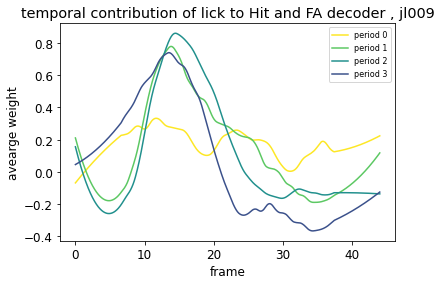

In [119]:
smooth = True
day_groups = day_groups_all[mouse_id]
title = 'temporal contribution of lick to Hit and FA decoder , {}'.format(mouse_name)
if smooth:
    figname = 'figure2206/decode_lick/weight_decoding_HitFA_fromlick_day_smooth_{}'.format(mouse_name)
else:
    figname = 'figure2206/decode_lick/weight_decoding_HitFA_fromlick_day_raw_{}'.format(mouse_name)
utils.plot_avg_weight(day_groups, valid_days, hf_weights, hf_accs, title, smooth)

## accs

In [ ]:
        plt.rcParams['font.size'] = 15
        plt.rcParams['legend.fontsize'] = 12
        plt.figure(figsize=(10, 5))
        x = np.arange(len(valid_days))
        xx, yy = utils.remove_false(x, hf_accs)
        plt.plot(xx, yy, label='Hit and FA', color='blue')
#         xx, yy = utils.remove_false(x, mc_accs)
#         plt.plot(xx, yy, label='Miss and CR', color='orange')
        xx, yy = utils.remove_false(x, rl_performance)
        plt.plot(xx, yy, label='reinforce', color='black', linestyle=':')
        xx, yy = utils.remove_false(x, pb_performance)
        plt.plot(xx, yy, label='reinforce', color='red', linestyle=':')
        plt.xlabel('day')
        plt.ylabel('accuracy')
        plt.title('Hit or FA decoding accuracy, {}'.format(mouse_name))
        plt.axhline(0.5, linestyle=':', color='gray', alpha=0.5)
        plt.ylim([0.3,1])
        plt.legend(loc=4)
        plt.xticks(x, labels=valid_days)
        ax = plt.gca()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        # plt.savefig('figure/decode_lick/decoding_HitFA_fromlick_day_raw_{}'.format(mouse_name))
        plt.close()

# decoding from all

In [165]:
mouse_id = 1
avg_weight = True
n_first_frame = 5
mouse_name = mouse_names[mouse_id]
disk = disks[mouse_id]

data_path = "{}_behavimaging.mat".format(mouse_name)
mat = scipy.io.loadmat(data_path)
data = mat['behavimaging']
blocks = []
valid_days = []
for day in range(1, nDays+1):
    iblocks = utils.daily_blocks(data, day)
    if len(iblocks)>0:
        valid_days.append(day)

if mouse_name == 'jl009':
    valid_days = [1, 2, 3, 5, 6, 7, 8, 9, 15]
if mouse_name == 'fz017':
    valid_days = [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 23, 24, 25, 26]

all_acc = np.zeros((3, len(valid_days))) # prediction acc with all activities in the time window
pb_acc = np.zeros((3, len(valid_days))) 
pre_window=45

stim_weights = []
prelick_weights = []
postlick_weights = []
for i, day in enumerate(valid_days):
    print('-------------------day {}---------------------'.format(day))
    print('******** predict with activities in [T-{}, T+45]'.format(pre_window))
    iblocks = utils.daily_blocks(data, day)
    if len(iblocks)>0:
        daily_cues = []
        daily_outcomes = []
        daily_responses = []
        daily_firstlicks = []
        daily_alllicks = []
        valid = True
        for j in iblocks:
            block = data[0, j]
            # normalize doesn't have much effect on the result, so set it to False
            cues, outcomes, firstlicks, stim_resp, alllicks = utils.block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False)
            if len(daily_responses) > 0:
                if daily_responses[0].shape != stim_resp.shape:
                    valid = False
            if valid == True:
                daily_cues.append(cues)
                daily_outcomes.append(outcomes)
                daily_responses.append(stim_resp)
                daily_firstlicks.append(firstlicks)
                daily_alllicks.append(alllicks)

        daily_cues = np.hstack(daily_cues)
        daily_outcomes = np.hstack(daily_outcomes)
        daily_responses = np.vstack(daily_responses)
        daily_alllicks = np.vstack(daily_alllicks)

    nanflag = np.sum(np.isnan(daily_responses.reshape(len(daily_responses), -1)), axis=1)
    inotnan = np.where(nanflag==0)
    daily_responses = daily_responses[inotnan]
    daily_cues = daily_cues[inotnan]
    daily_outcomes = daily_outcomes[inotnan]
    daily_alllicks = daily_alllicks[inotnan]
    NT, NA, NF = daily_responses.shape


    NT = len(daily_cues) # number of trials
    stim = np.ones(daily_cues.shape)
    stim[np.where(daily_cues==2)] = 0 
    stim[np.where(daily_cues==4)] = 0
    stim = np.multiply((stim == 1), 1) # target: 1    foil: 0, regardless of probe or reinforce trial

    spks = daily_responses[:, :, pre_window:(pre_window+n_first_frame)]
    NT, NA, NF = spks.shape
    
    if avg_weight:
        spks = spks.mean(axis=1)
    else:
        spks = spks.reshape(spks.shape[0], -1)
    acc, weights = classifier(spks, stim)
    if not avg_weight:
        weights = weights.reshape((NA, NF))
    print('accuracy predicting stimulus identity on test set: ', acc)
    all_acc[0, i] = acc
    stim_weights.append(weights)
    
    NT, NA, NF = daily_responses.shape
    if avg_weight:
        spks = daily_responses.mean(axis=1)
    else:
        spks = daily_responses.reshape(daily_responses.shape[0], -1)
    postlick = np.ones(daily_outcomes.shape)
    postlick[np.where(daily_outcomes==2)] = 0 
    postlick[np.where(daily_outcomes==4)] = 0
    postlick = np.multiply((postlick == 1), 1)  # lick: 1, nolick: 0
    if (np.mean(postlick) == 0) or (np.mean(postlick) == 1):
        acc, weights = 0.5, False
    else:
        acc, weights = classifier(spks, postlick)
        if not avg_weight: weights = weights.reshape((NA, NF))
    all_acc[1, i] = acc
    print('accuracy predicting postlick on test set: ', acc)
    postlick_weights.append(weights)

    prelick = (np.sum(daily_alllicks[:, (pre_window-30):(pre_window-15)], axis=1) > 0)
    prelick = np.multiply((prelick == 1), 1)
    if (np.mean(prelick) == 0) or (np.mean(prelick) == 1):
        acc, weights = 0.5, False
    else:
        acc, weights = classifier(spks, prelick)
        if not avg_weight: weights = weights.reshape((NA, NF))
    all_acc[2, i] = acc
    print('accuracy predicting prelick on test set: ', acc)
    prelick_weights.append(weights)

-------------------day 1---------------------
******** predict with activities in [T-45, T+45]
valid samples: 300
accuracy predicting stimulus identity on test set:  0.511
valid samples: 202
accuracy predicting postlick on test set:  0.7249999999999999
valid samples: 182
accuracy predicting prelick on test set:  0.721311475409836
-------------------day 2---------------------
******** predict with activities in [T-45, T+45]
valid samples: 300
accuracy predicting stimulus identity on test set:  0.47800000000000004
valid samples: 264
accuracy predicting postlick on test set:  0.7193181818181819
valid samples: 194
accuracy predicting prelick on test set:  0.7276923076923076
-------------------day 4---------------------
******** predict with activities in [T-45, T+45]
valid samples: 200
accuracy predicting stimulus identity on test set:  0.6238805970149255
valid samples: 82
accuracy predicting postlick on test set:  0.8321428571428571
valid samples: 72
accuracy predicting prelick on test se

### weights

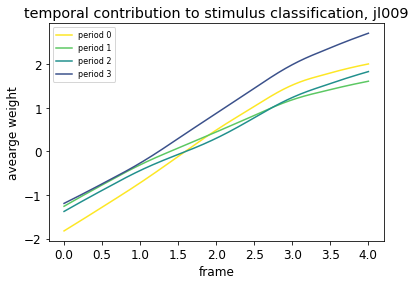

In [161]:
smooth = True
day_groups = day_groups_all[mouse_id]
title = 'temporal contribution to stimulus classification, {}'.format(mouse_name)
if smooth:
    figname = 'figure2206/decode_activity/weight_decoding_stim_fromspk_smooth_{}'.format(mouse_name)
else:
    figname = 'figure2206/decode_activity/weight_decoding_stim_fromspk_raw_{}'.format(mouse_name)
if avg_weight: 
    utils.plot_avg_weight(day_groups, valid_days, stim_weights, all_acc[0], title, smooth)
else:
    utils.plot_weight(day_groups, valid_days, stim_weights, all_acc[0], title, smooth)

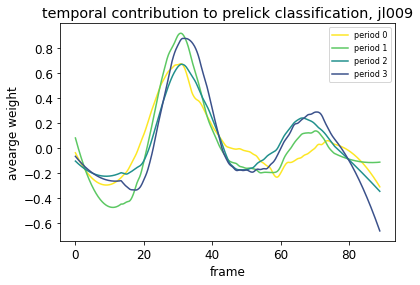

In [112]:
title = 'temporal contribution to prelick classification, {}'.format(mouse_name)
if smooth:
    figname = 'figure2206/decode_activity/weight_decoding_prelick_fromspk_smooth_{}'.format(mouse_name)
else:
    figname = 'figure2206/decode_activity/weight_decoding_prelick_fromspk_raw_{}'.format(mouse_name)
if avg_weight: 
    utils.plot_avg_weight(day_groups, valid_days, prelick_weights, all_acc[2], title, smooth)
else:
    utils.plot_weight(day_groups, valid_days, prelick_weights, all_acc[2], title, smooth)

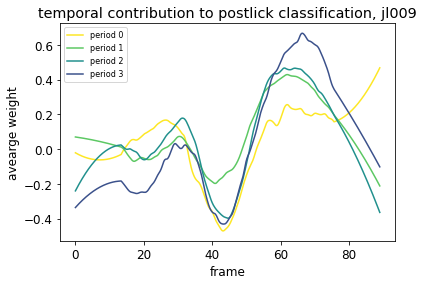

In [113]:
title = 'temporal contribution to postlick classification, {}'.format(mouse_name)
if smooth:
    figname = 'figure2206/decode_activity/weight_decoding_postlick_fromspk_smooth_{}'.format(mouse_name)
else:
    figname = 'figure2206/decode_activity/weight_decoding_postlick_fromspk_raw_{}'.format(mouse_name)
if avg_weight: 
    utils.plot_avg_weight(day_groups, valid_days, postlick_weights, all_acc[1], title, smooth)
else:
    utils.plot_weight(day_groups, valid_days, postlick_weights, all_acc[1], title, smooth)

### acc

(0.3, 1.0)

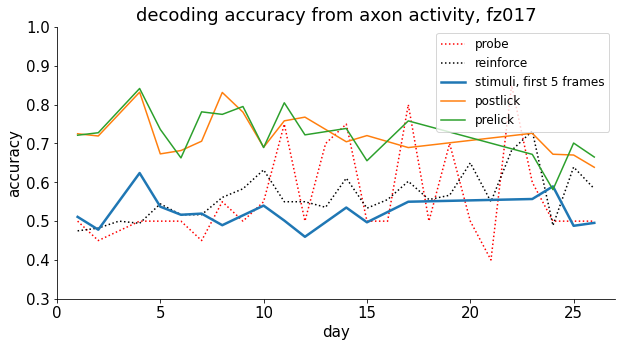

In [166]:
beh_data_path = "{}:/Jenni/{}/behavior/justbehavior".format(disks[mouse_id], mouse_name)
if mouse_name == 'fz006':
    beh_data_path = 'Y:/sarah/fz006/behavior/justbehavior'
fnames = [_ for _ in os.listdir(beh_data_path) if _.endswith('txt')]

from tkinter import Tcl
fnames = Tcl().call('lsort', '-dict', fnames)

nBlocks = len(fnames)
pbRes = np.zeros((4, nBlocks))
rlRes = np.zeros((4, nBlocks))
nPB = np.zeros(nBlocks)
days = np.zeros(nBlocks)
for i in range(nBlocks):
    tmp = fnames[i].split('_')[-1]
    days[i] = int(tmp.split('v')[0])
    fpath = os.path.join(beh_data_path, fnames[i])
    bmat = utils.load_behavior_txt(fpath)
    behavior = bmat[:, 12].reshape(-1).astype(int)
    outcome = bmat[:, 3].reshape(-1).astype(int)
    nPB[i] = np.sum(behavior==0)
    if nPB[i] > 0:
        pbIdx = np.where(behavior==0)
        pbOutcome = outcome[pbIdx]
        for j in range(4):
            pbRes[j, i] = np.sum(pbOutcome == j+1) / nPB[i]

    rlIdx = np.where(behavior==1)
    rlOutcome = outcome[rlIdx]
    for j in range(4):
        rlRes[j, i] = np.sum(rlOutcome == j+1) / (100 - nPB[i])
days = days.astype('int')

ptrue = pbRes[0] + pbRes[3]
rtrue = rlRes[0] + rlRes[3]

daymax = days.max()
dptrue = np.zeros(daymax)
drtrue = np.zeros(daymax)
for d in range(daymax):
    dind = np.where(days==(d+1))
    dnPB = nPB[dind]
    pbind = np.where(dnPB == 20)[0]
    # if has probe trial in a day
    if pbind.shape[0] > 0:
        tmp = ptrue[dind]
        dptrue[d] = np.average(tmp[pbind], weights=dnPB[pbind])
    weights = 100 - dnPB
    drtrue[d] = np.average(rtrue[dind], weights=weights)

colors = np.array(["green", "blue"])
x = np.arange(1, daymax+1)
plt.figure(figsize=(10, 5))
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 12
dp_nonzero = np.where(dptrue>0)
dr_nonzero = np.where(drtrue>0)
plt.plot(x[dp_nonzero], dptrue[dp_nonzero], label='probe', color='red', linestyle=':')
plt.plot(x[dr_nonzero], drtrue[dr_nonzero], label='reinforce', color='black', linestyle=':')
plt.xlim([0, daymax+1])
plt.plot(valid_days, all_acc[0], label='stimuli', linewidth=2.5)
plt.plot(valid_days, all_acc[1], label='postlick')
plt.plot(valid_days, all_acc[2], label='prelick')
plt.title('decoding accuracy from axon activity, {}'.format(mouse_name))
# plt.xticks(x, days)
plt.xlabel('day')
plt.ylabel('accuracy')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend()
plt.ylim([0.3, 1])
# plt.savefig('figure2206/decoding_all_{}'.format(mouse_name))
# plt.close()

## all
run all mice at once

In [ ]:
mouse_id = 0
for mouse_id in range(4):
    # for mouse_id in range(4):
    mouse_name = mouse_names[mouse_id]
    disk = disks[mouse_id]

    data_path = "{}_behavimaging.mat".format(mouse_name)
    mat = scipy.io.loadmat(data_path)
    data = mat['behavimaging']
    blocks = []
    valid_days = []
    for day in range(1, nDays+1):
        iblocks = utils.daily_blocks(data, day)
        if len(iblocks)>0:
            valid_days.append(day)

    if mouse_name == 'jl009':
        valid_days = [1, 2, 3, 5, 6, 7, 8, 9, 15]
    if mouse_name == 'fz017':
        valid_days = [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 23, 24, 25, 26]

    all_acc = np.zeros((3, len(valid_days))) # prediction acc with all activities in the time window
    pb_acc = np.zeros((3, len(valid_days))) 
    pre_window=45
    
    stim_weights = []
    prelick_weights = []
    postlick_weights = []
    for i, day in enumerate(valid_days):
        print('-------------------day {}---------------------'.format(day))
        print('******** predict with activities in [T-{}, T+45]'.format(pre_window))
        iblocks = utils.daily_blocks(data, day)
        if len(iblocks)>0:
            daily_cues = []
            daily_outcomes = []
            daily_responses = []
            daily_firstlicks = []
            daily_alllicks = []
            valid = True
            for j in iblocks:
                block = data[0, j]
                # normalize doesn't have much effect on the result, so set it to False
                cues, outcomes, firstlicks, stim_resp, alllicks = utils.block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False)
                if len(daily_responses) > 0:
                    if daily_responses[0].shape != stim_resp.shape:
                        valid = False
                if valid == True:
                    daily_cues.append(cues)
                    daily_outcomes.append(outcomes)
                    daily_responses.append(stim_resp)
                    daily_firstlicks.append(firstlicks)
                    daily_alllicks.append(alllicks)

            daily_cues = np.hstack(daily_cues)
            daily_outcomes = np.hstack(daily_outcomes)
            daily_responses = np.vstack(daily_responses)
            daily_alllicks = np.vstack(daily_alllicks)

        nanflag = np.sum(np.isnan(daily_responses.reshape(len(daily_responses), -1)), axis=1)
        inotnan = np.where(nanflag==0)
        daily_responses = daily_responses[inotnan]
        daily_cues = daily_cues[inotnan]
        daily_outcomes = daily_outcomes[inotnan]
        daily_alllicks = daily_alllicks[inotnan]
        NT, NA, NF = daily_responses.shape


        NT = len(daily_cues) # number of trials
        stim = np.ones(daily_cues.shape)
        stim[np.where(daily_cues==2)] = 0 
        stim[np.where(daily_cues==4)] = 0
        stim = np.multiply((stim == 1), 1) # target: 1    foil: 0, regardless of probe or reinforce trial
        
        spks = daily_responses[:, :, pre_window:]
        spks = spks.reshape(spks.shape[0], -1)
        acc, weights = classifier(spks, stim)
        weights = weights.reshape((NA, int(NF/2)))
        print('accuracy predicting stimulus identity on test set: ', acc)
        all_acc[0, i] = acc
        stim_weights.append(weights)
        
        spks = daily_responses.reshape(daily_responses.shape[0], -1)
        postlick = np.ones(daily_outcomes.shape)
        postlick[np.where(daily_outcomes==2)] = 0 
        postlick[np.where(daily_outcomes==4)] = 0
        postlick = np.multiply((postlick == 1), 1)  # lick: 1, nolick: 0
        if (np.mean(postlick) == 0) or (np.mean(postlick) == 1):
            acc, weights = 0.5, False
        else:
            acc, weights = classifier(spks, postlick)
            weights = weights.reshape((NA, NF))
        all_acc[1, i] = acc
        print('accuracy predicting postlick on test set: ', acc)
        postlick_weights.append(weights)

        prelick = (np.sum(daily_alllicks[:, (pre_window-30):(pre_window-15)], axis=1) > 0)
        prelick = np.multiply((prelick == 1), 1)
        if (np.mean(prelick) == 0) or (np.mean(prelick) == 1):
            acc, weights = 0.5, False
        else:
            acc, weights = classifier(spks, prelick)
            weights = weights.reshape((NA, NF))
        all_acc[2, i] = acc
        print('accuracy predicting prelick on test set: ', acc)
        prelick_weights.append(weights)
        
    # plot weight
    cmap = plt.cm.get_cmap('viridis_r')
    plt.rcParams['font.size'] = 12
    plt.rcParams['legend.fontsize'] = 8
    plt.figure(figsize=(6, 4))
    day_groups = day_groups_all[mouse_id]
    for i, days in enumerate(day_groups):
        wsum = 0
        for d in days:
            idx = np.where(np.array(valid_days) == d)[0][0]
            # weight = stim_weights[idx]
            weight = np.abs(stim_weights[idx])
            # wsum += np.mean(weight, axis=0)
            wsum += (np.mean(weight, axis=0) - np.mean(weight))
        wavg = wsum/len(days)
        # wavg = wavg - np.mean(wavg[:45])
        xx, yy = smooth_line(np.arange(len(wavg)), wavg)
        plt.plot(xx, yy, label='period {}'.format(i), color=cmap(i/len(day_groups)))
    plt.legend()
    plt.title('temporal contribution to stimulus classification, {}'.format(mouse_name))
    plt.xlabel('frame')
    plt.ylabel('avearge weight')
    plt.savefig('figure2206/decode_activity/weight_decoding_stim_fromspk_smooth_{}'.format(mouse_name))
    plt.close()
    
    plt.figure(figsize=(8, 4))
    for i, days in enumerate(day_groups):
        wsum = 0
        for d in days:
            idx = np.where(np.array(valid_days) == d)[0][0]
            # weight = prelick_weights[idx]
            weight = np.abs(prelick_weights[idx])
            # wsum += np.mean(weight, axis=0)
            wsum += (np.mean(weight, axis=0) - np.mean(weight))
        wavg = wsum/len(days)
        # wavg = wavg - np.mean(wavg[:45])
        xx, yy = smooth_line(np.arange(len(wavg)), wavg)
        plt.plot(xx, yy, label='period {}'.format(i), color=cmap(i/len(day_groups)))
        plt.axvline(45, color='gray', linestyle=":", alpha=0.5)
    plt.legend()
    plt.title('temporal contribution to prelick classification, {}'.format(mouse_name))
    plt.xlabel('frame')
    plt.ylabel('avearge weight')
    plt.savefig('figure2206/decode_activity/weight_decoding_prelick_fromspk_smooth_{}'.format(mouse_name))
    plt.close()

    plt.figure(figsize=(8, 4))
    for i, days in enumerate(day_groups):
        wsum = 0
        for d in days:
            idx = np.where(np.array(valid_days) == d)[0][0]
            # weight = postlick_weights[idx]
            weight = np.abs(postlick_weights[idx])
            # wsum += np.mean(weight, axis=0)
            wsum += (np.mean(weight, axis=0) - np.mean(weight))
        wavg = wsum/len(days)
        # wavg = wavg - np.mean(wavg[:45])
        xx, yy = smooth_line(np.arange(len(wavg)), wavg)
        plt.plot(xx, yy, label='period {}'.format(i), color=cmap(i/len(day_groups)))
        plt.axvline(45, color='gray', linestyle=":", alpha=0.5)
    plt.legend()
    plt.title('temporal contribution to postlick classification, {}'.format(mouse_name))
    plt.xlabel('frame')
    plt.ylabel('avearge weight')
    plt.savefig('figure2206/decode_activity/weight_decoding_postlick_fromspk_smooth_{}'.format(mouse_name))
    plt.close()
    
    cmap = plt.cm.get_cmap('viridis_r')
    plt.rcParams['font.size'] = 12
    plt.rcParams['legend.fontsize'] = 8
    plt.figure(figsize=(6, 4))
    day_groups = day_groups_all[mouse_id]
    for i, days in enumerate(day_groups):
        wsum = 0
        for d in days:
            idx = np.where(np.array(valid_days) == d)[0][0]
            # weight = stim_weights[idx]
            weight = np.abs(stim_weights[idx])
            # wsum += np.mean(weight, axis=0)
            wsum += (np.mean(weight, axis=0) - np.mean(weight))
        wavg = wsum/len(days)
        # wavg = wavg - np.mean(wavg[:45])
        plt.plot(np.arange(len(wavg)), wavg, label='period {}'.format(i), color=cmap(i/len(day_groups)))
    plt.legend()
    plt.title('temporal contribution to stimulus classification, {}'.format(mouse_name))
    plt.xlabel('frame')
    plt.ylabel('avearge weight')
    plt.savefig('figure2206/decode_activity/weight_decoding_stim_fromspk_raw_{}'.format(mouse_name))
    plt.close()
    
    plt.figure(figsize=(8, 4))
    for i, days in enumerate(day_groups):
        wsum = 0
        for d in days:
            idx = np.where(np.array(valid_days) == d)[0][0]
            # weight = prelick_weights[idx]
            weight = np.abs(prelick_weights[idx])
            # wsum += np.mean(weight, axis=0)
            wsum += (np.mean(weight, axis=0) - np.mean(weight))
        wavg = wsum/len(days)
        # wavg = wavg - np.mean(wavg[:45])
        plt.plot(np.arange(len(wavg)), wavg, label='period {}'.format(i), color=cmap(i/len(day_groups)))
        plt.axvline(45, color='gray', linestyle=":", alpha=0.5)
    plt.legend()
    plt.title('temporal contribution to prelick classification, {}'.format(mouse_name))
    plt.xlabel('frame')
    plt.ylabel('avearge weight')
    plt.savefig('figure2206/decode_activity/weight_decoding_prelick_fromspk_raw_{}'.format(mouse_name))
    plt.close()

    plt.figure(figsize=(8, 4))
    for i, days in enumerate(day_groups):
        wsum = 0
        for d in days:
            idx = np.where(np.array(valid_days) == d)[0][0]
            # weight = postlick_weights[idx]
            weight = np.abs(postlick_weights[idx])
            # wsum += np.mean(weight, axis=0)
            wsum += (np.mean(weight, axis=0) - np.mean(weight))
        wavg = wsum/len(days)
        # wavg = wavg - np.mean(wavg[:45])
        plt.plot(np.arange(len(wavg)), wavg, label='period {}'.format(i), color=cmap(i/len(day_groups)))
        plt.axvline(45, color='gray', linestyle=":", alpha=0.5)
    plt.legend()
    plt.title('temporal contribution to postlick classification, {}'.format(mouse_name))
    plt.xlabel('frame')
    plt.ylabel('avearge weight')
    plt.savefig('figure2206/decode_activity/weight_decoding_postlick_fromspk_raw_{}'.format(mouse_name))
    plt.close()


    beh_data_path = "{}:/Jenni/{}/behavior/justbehavior".format(disks[mouse_id], mouse_name)
    if mouse_name == 'fz006':
        beh_data_path = 'Y:/sarah/fz006/behavior/justbehavior'
    fnames = [_ for _ in os.listdir(beh_data_path) if _.endswith('txt')]

    from tkinter import Tcl
    fnames = Tcl().call('lsort', '-dict', fnames)

    nBlocks = len(fnames)
    pbRes = np.zeros((4, nBlocks))
    rlRes = np.zeros((4, nBlocks))
    nPB = np.zeros(nBlocks)
    days = np.zeros(nBlocks)
    for i in range(nBlocks):
        tmp = fnames[i].split('_')[-1]
        days[i] = int(tmp.split('v')[0])
        fpath = os.path.join(beh_data_path, fnames[i])
        bmat = utils.load_behavior_txt(fpath)
        behavior = bmat[:, 12].reshape(-1).astype(int)
        outcome = bmat[:, 3].reshape(-1).astype(int)
        nPB[i] = np.sum(behavior==0)
        if nPB[i] > 0:
            pbIdx = np.where(behavior==0)
            pbOutcome = outcome[pbIdx]
            for j in range(4):
                pbRes[j, i] = np.sum(pbOutcome == j+1) / nPB[i]

        rlIdx = np.where(behavior==1)
        rlOutcome = outcome[rlIdx]
        for j in range(4):
            rlRes[j, i] = np.sum(rlOutcome == j+1) / (100 - nPB[i])
    days = days.astype('int')

    ptrue = pbRes[0] + pbRes[3]
    rtrue = rlRes[0] + rlRes[3]

    daymax = days.max()
    dptrue = np.zeros(daymax)
    drtrue = np.zeros(daymax)
    for d in range(daymax):
        dind = np.where(days==(d+1))
        dnPB = nPB[dind]
        pbind = np.where(dnPB == 20)[0]
        # if has probe trial in a day
        if pbind.shape[0] > 0:
            tmp = ptrue[dind]
            dptrue[d] = np.average(tmp[pbind], weights=dnPB[pbind])
        weights = 100 - dnPB
        drtrue[d] = np.average(rtrue[dind], weights=weights)

    colors = np.array(["green", "blue"])
    x = np.arange(1, daymax+1)
    plt.figure(figsize=(10, 5))
    plt.rcParams['font.size'] = 15
    plt.rcParams['legend.fontsize'] = 12
    dp_nonzero = np.where(dptrue>0)
    dr_nonzero = np.where(drtrue>0)
    plt.plot(x[dp_nonzero], dptrue[dp_nonzero], label='probe', color='red', linestyle=':')
    plt.plot(x[dr_nonzero], drtrue[dr_nonzero], label='reinforce', color='black', linestyle=':')
    plt.xlim([0, daymax+1])
    plt.plot(valid_days, all_acc[0], label='stimuli', linewidth=2.5)
    plt.plot(valid_days, all_acc[1], label='postlick')
    plt.plot(valid_days, all_acc[2], label='prelick')
    plt.title('decoding accuracy from axon activity, {}'.format(mouse_name))
    # plt.xticks(x, days)
    plt.xlabel('day')
    plt.ylabel('accuracy')
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.legend()
    plt.ylim([0.3, 1])
    plt.savefig('figure2206/decoding_all_{}'.format(mouse_name))
    plt.close()

# First 5 frames

In [177]:
mouse_id = 1
avg_weight = False
n_first_frame = 5
mouse_name = mouse_names[mouse_id]
disk = disks[mouse_id]

data_path = "{}_behavimaging.mat".format(mouse_name)
mat = scipy.io.loadmat(data_path)
data = mat['behavimaging']
blocks = []
valid_days = []
for day in range(1, nDays+1):
    iblocks = utils.daily_blocks(data, day)
    if len(iblocks)>0:
        valid_days.append(day)

if mouse_name == 'jl009':
    valid_days = [1, 2, 3, 5, 6, 7, 8, 9, 15]
if mouse_name == 'fz017':
    valid_days = [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 23, 24, 25, 26]

all_acc = np.zeros((3, len(valid_days))) # prediction acc with all activities in the time window
pb_acc = np.zeros((3, len(valid_days))) 
pre_window=45

stim_weights_frame = []
stim_weights_all = []
prelick_weights = []
postlick_weights = []
for i, day in enumerate(valid_days):
    print('-------------------day {}---------------------'.format(day))
    print('******** predict with activities in [T-{}, T+45]'.format(pre_window))
    iblocks = utils.daily_blocks(data, day)
    if len(iblocks)>0:
        daily_cues = []
        daily_outcomes = []
        daily_responses = []
        daily_firstlicks = []
        daily_alllicks = []
        valid = True
        for j in iblocks:
            block = data[0, j]
            # normalize doesn't have much effect on the result, so set it to False
            cues, outcomes, firstlicks, stim_resp, alllicks = utils.block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False)
            if len(daily_responses) > 0:
                if daily_responses[0].shape != stim_resp.shape:
                    valid = False
            if valid == True:
                daily_cues.append(cues)
                daily_outcomes.append(outcomes)
                daily_responses.append(stim_resp)
                daily_firstlicks.append(firstlicks)
                daily_alllicks.append(alllicks)

        daily_cues = np.hstack(daily_cues)
        daily_outcomes = np.hstack(daily_outcomes)
        daily_responses = np.vstack(daily_responses)
        daily_alllicks = np.vstack(daily_alllicks)

    nanflag = np.sum(np.isnan(daily_responses.reshape(len(daily_responses), -1)), axis=1)
    inotnan = np.where(nanflag==0)
    daily_responses = daily_responses[inotnan]
    daily_cues = daily_cues[inotnan]
    daily_outcomes = daily_outcomes[inotnan]
    daily_alllicks = daily_alllicks[inotnan]
    NT, NA, NF = daily_responses.shape


    NT = len(daily_cues) # number of trials
    stim = np.ones(daily_cues.shape)
    stim[np.where(daily_cues==2)] = 0 
    stim[np.where(daily_cues==4)] = 0
    stim = np.multiply((stim == 1), 1) # target: 1    foil: 0, regardless of probe or reinforce trial

    spks = daily_responses[:, :, pre_window:(pre_window+n_first_frame)]
    NT, NA, NF = spks.shape
    
    if avg_weight:
        spks = spks.mean(axis=1)
    else:
        spks = spks.reshape(spks.shape[0], -1)
    acc, weights = classifier(spks, stim)
    if not avg_weight:
        weights = weights.reshape((NA, NF))
    print('accuracy predicting stimulus identity on test set: ', acc)
    all_acc[0, i] = acc
    stim_weights_frame.append(weights)
    
    spks = daily_responses[:, :, pre_window:]
    NT, NA, NF = spks.shape
    
    if avg_weight:
        spks = spks.mean(axis=1)
    else:
        spks = spks.reshape(spks.shape[0], -1)
    acc, weights = classifier(spks, stim)
    if not avg_weight:
        weights = weights.reshape((NA, NF))
    print('accuracy predicting stimulus identity on test set: ', acc)
    all_acc[1, i] = acc
    stim_weights_all.append(weights)

-------------------day 1---------------------
******** predict with activities in [T-45, T+45]
valid samples: 300
accuracy predicting stimulus identity on test set:  0.47300000000000003
valid samples: 300
accuracy predicting stimulus identity on test set:  0.47400000000000003
-------------------day 2---------------------
******** predict with activities in [T-45, T+45]
valid samples: 300
accuracy predicting stimulus identity on test set:  0.5119999999999999
valid samples: 300
accuracy predicting stimulus identity on test set:  0.585
-------------------day 4---------------------
******** predict with activities in [T-45, T+45]
valid samples: 200
accuracy predicting stimulus identity on test set:  0.5134328358208956
valid samples: 200
accuracy predicting stimulus identity on test set:  0.5656716417910447
-------------------day 5---------------------
******** predict with activities in [T-45, T+45]
valid samples: 200
accuracy predicting stimulus identity on test set:  0.5104477611940299
v

(0.3, 1.0)

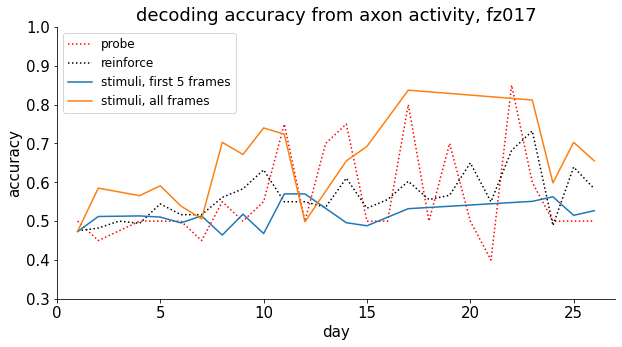

In [178]:
beh_data_path = "{}:/Jenni/{}/behavior/justbehavior".format(disks[mouse_id], mouse_name)
if mouse_name == 'fz006':
    beh_data_path = 'Y:/sarah/fz006/behavior/justbehavior'
fnames = [_ for _ in os.listdir(beh_data_path) if _.endswith('txt')]

from tkinter import Tcl
fnames = Tcl().call('lsort', '-dict', fnames)

nBlocks = len(fnames)
pbRes = np.zeros((4, nBlocks))
rlRes = np.zeros((4, nBlocks))
nPB = np.zeros(nBlocks)
days = np.zeros(nBlocks)
for i in range(nBlocks):
    tmp = fnames[i].split('_')[-1]
    days[i] = int(tmp.split('v')[0])
    fpath = os.path.join(beh_data_path, fnames[i])
    bmat = utils.load_behavior_txt(fpath)
    behavior = bmat[:, 12].reshape(-1).astype(int)
    outcome = bmat[:, 3].reshape(-1).astype(int)
    nPB[i] = np.sum(behavior==0)
    if nPB[i] > 0:
        pbIdx = np.where(behavior==0)
        pbOutcome = outcome[pbIdx]
        for j in range(4):
            pbRes[j, i] = np.sum(pbOutcome == j+1) / nPB[i]

    rlIdx = np.where(behavior==1)
    rlOutcome = outcome[rlIdx]
    for j in range(4):
        rlRes[j, i] = np.sum(rlOutcome == j+1) / (100 - nPB[i])
days = days.astype('int')

ptrue = pbRes[0] + pbRes[3]
rtrue = rlRes[0] + rlRes[3]

daymax = days.max()
dptrue = np.zeros(daymax)
drtrue = np.zeros(daymax)
for d in range(daymax):
    dind = np.where(days==(d+1))
    dnPB = nPB[dind]
    pbind = np.where(dnPB == 20)[0]
    # if has probe trial in a day
    if pbind.shape[0] > 0:
        tmp = ptrue[dind]
        dptrue[d] = np.average(tmp[pbind], weights=dnPB[pbind])
    weights = 100 - dnPB
    drtrue[d] = np.average(rtrue[dind], weights=weights)

colors = np.array(["green", "blue"])
x = np.arange(1, daymax+1)
plt.figure(figsize=(10, 5))
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 12
dp_nonzero = np.where(dptrue>0)
dr_nonzero = np.where(drtrue>0)
plt.plot(x[dp_nonzero], dptrue[dp_nonzero], label='probe', color='red', linestyle=':')
plt.plot(x[dr_nonzero], drtrue[dr_nonzero], label='reinforce', color='black', linestyle=':')
plt.xlim([0, daymax+1])
plt.plot(valid_days, all_acc[0], label='stimuli, first 5 frames')
plt.plot(valid_days, all_acc[1], label='stimuli, all frames')
plt.title('decoding accuracy from axon activity, {}'.format(mouse_name))
# plt.xticks(x, days)
plt.xlabel('day')
plt.ylabel('accuracy')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend()
plt.ylim([0.3, 1])
# plt.savefig('figure2206/decoding_all_{}'.format(mouse_name))
# plt.close()